## Prerequesits
- [Pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html)
- [Glasbey](https://pypi.org/project/glasbey/)
- [Matplotlib](https://matplotlib.org/stable/users/installing.html)
- [Seaborn](https://seaborn.pydata.org/installing.html)
- [Numpy](https://numpy.org/install/)
- [Pytables](https://www.pytables.org/usersguide/installation.html)

## Introduction
This notebook is a collection of the data analysis and plotting code used for the paper. Admittedly, the code is not very clean and is not well-documented. We have tried to make it at least easily reproducible.

All the data for this notebook is stored in a single HDF5 file (`observation.hdf5`). The data is stored in a Pandas DataFrame. It is a slightly preprocessed version of the data obtained from the experiments. However, during the experiments, we collected data into multiple files, which later needed to be merged. For this, we used a part of the CLUE framework. To make this notebook standalone, we stored these merged files in the HDF5 file.

The data is organized under the following keys:
 - stats: Locust statistics from each experiment.
 - stats_history_aggregated: Aggregated locust statistics from each experiment.
 - nodes: Observations about the nodes.
 - pods: Observations about each pod.
 - pods_energy: Observations about the energy consumption of each pod per experiment.
 - run_stats: Statistics about the experiments.
  
## Overview
This notebook is divided into the following sections:
 1. [Imports](#Imports-and-Constants)
 2. [Data Loading](#Data-Loading)
 3. [Service Quality Table](#Service-Quality-Table)
 4. [Resource Utilization](#Resource-Utilization)
 5. [Scaling and Energy Consumption](#Scaling-and-Energy-Consumption)


## Imports and Constants

In [1]:
%load_ext autoreload
%autoreload 1

In [ ]:
# %aimport exv2.experiment_results 

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glasbey
import numpy as np
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_theme(rc={'figure.figsize':(12, 6)})
sns.set_context("paper")
sns.set_style("whitegrid")

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

palette = glasbey.create_block_palette(
    [4, 3, 3, 2, 2],
    colorblind_safe=True,
    cvd_severity=90
)
sns.set_palette(palette)
#full_stack_focus = ["baseline","monolith","serverless","norec","runtime-replacement"]
full_stack_focus = ["baseline_vanilla_full","monolith_feature_monolith_full","serverless_feature_serverless_full","norec_feature_norecommendations_full","jvm_jvm-impoove_full"]
lable_names = {
    # experiment branch names and run configurations
    "baseline_vanilla_full": "Microservices",
    'monolith_feature_monolith_full': "Monolith",
    'serverless_feature_serverless_full' : "Serverless",
    'jvm_jvm-impoove_full': "Runtime Improvement",
    'norec_feature_norecommendations_full' : "Service Reduction",
    
    # workload names
    'exp_scale_pausing': "Pausing",
    "exp_scale_rampup": "Stress",
    "exp_scale_fixed": "Fixed",
    "exp_scale_shaped": "Regular",
}


run_vars = ['exp_start', 'exp_branch', 'exp_workload', 'run_iteration']

In [3]:
# Environment configuration and constants

ws_price = 0.5 / 3_600_000 # based on germany mean kWh price

# AWS cost-model
serverless_price = 0.0000166667  # based on aws lambda price per GB-s  (frankfurt)
memory_second_price = 0.00511 / 1024 /60 # $/MBs based on AWS nfragate memory price per hour (frankfurt) 
vCPU_second_price = 0.04656 / 60 # $/vCPU based on AWS nfragate memory price per hour (frankfurt) 

node_model = {
    "sm-gpu": 32704316//1024,
    "ise-knode6": 32719632//1024,
    "ise-knode1": 32761604//1024,
}

pod_configuration = {
    "teastore-recommender": {"cpu": 2600, "memory": 1332},
    "teastore-webui": {"cpu": 1300, "memory": 1950},
    "teastore-image": {"cpu": 1300, "memory": 1950},
    "teastore-auth": {"cpu": 585, "memory": 1332},
    'teastore-registry':{"cpu": 1000, "memory": 1024}, # not set by default ....
    'teastore-persistence':{"cpu": 1000, "memory": 1024}, # not set by default ....
    'teastore-db':{"cpu": 1000, "memory": 1024}, # not set by default ....
    "teastore-all": {"cpu":1950, "memory":2663},
    "auth": {"cpu": 500, "memory": 500},
}

general_allowance = {
    "teastore-recommender": {"cpu": 2600, "memory": 1332},
    "teastore-webui": {"cpu": 1300, "memory": 1950},
    "teastore-image": {"cpu": 1300, "memory": 1950},
    "teastore-auth": {"cpu": 585, "memory": 1332},
    'teastore-registry':{"cpu": 1300, "memory": 1332}, 
    'teastore-persistence':{"cpu": 1300, "memory": 1332}, 
    'teastore-db':{"cpu": 1300, "memory": 1332},
    "teastore-all": {"cpu":1950, "memory":2663},
    "auth": {"cpu": 500, "memory": 500},
}

resouce_scale = {
    "baseline_vanilla_full": {
        'teastore-recommender':3,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':3,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":0,
    },
    'jvm_jvm-impoove_full': {
        'teastore-recommender':3,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':3,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":0,
    },
    'monolith_feature_monolith_full': {
        'teastore-recommender':0,
        'teastore-webui':0,
        'teastore-image':0,
        'teastore-auth':0,
        'teastore-registry':1,
        'teastore-persistence':0,
        'teastore-db':1,
        "teastore-all":3,
        "auth":0,
    },
    'norec_feature_norecommendations_full' : {
        'teastore-recommender':0,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':3,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":0,
    },
    'obs_feature_object-storage_full' : {
        'teastore-recommender':3,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':3,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":0,
    },
    'serverless_feature_serverless_full' : {
        'teastore-recommender':3,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':0,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":40, # infinite theorethical, we use the maximum possible on the nodes we use (12+8 cores) -> 40 functions fit
    },
    'serverless_incl_knative' : {
        'teastore-recommender':3,
        'teastore-webui':3,
        'teastore-image':3,
        'teastore-auth':0,
        'teastore-registry':1,
        'teastore-persistence':1,
        'teastore-db':1,
        "teastore-all":0,
        "auth":40, # infinite theorethical, we use the maximum possible on the nodes we use (12+8 cores) -> 40 functions fit
    },
}


In [ ]:
# # delete me when done

# exr = exv2.experiment_results.ExperimentResults("data/clean_run*", load_stats_history=True, remove_outliers=False) # type: ignore
# RUN_VARS = exv2.experiment_results.ExperimentResults.RUN_VARS # type: ignore

# assert("loadgenerator" not in (list(exr.pods['name'].unique())))
# assert("unkown" not in (list(exr.pods['instance'].unique())))


In [ ]:
# # delete me when done
# exr.stats_history_aggregated.to_hdf("observation.hdf5", key="stats_history_aggregated")
# exr.pods.to_hdf("observation.hdf5", key="pods")
# exr.stats.to_hdf("observation.hdf5", key="stats")
# exr.nodes.to_hdf("observation.hdf5", key="nodes")
# exr.pods_energy(energy_workloads=False).to_hdf("observation.hdf5", key="pods_energy")
# exr.run_stats().to_hdf("observation.hdf5", key="run_stats")


## Data Loading

In [21]:
from experiment_results import ExperimentResults

exp_results = ExperimentResults("data/results-a9fc574d-9d4c-4851-b85f-19e87eec3e71", sut="teastore", load_stats_history=True)

stats_history_aggregated_data = exp_results.load_stats_aggregated()
pods_data = exp_results.pods
stats_data = exp_results.stats
nodes_data = exp_results.nodes
pods_energy_data = exp_results.pods_energy()
run_stats_data = exp_results.run_stats()
stats_history_aggregated_data


,Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,Failures/s,50%,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%,exp_workload,exp_branch,exp_start,run_start,run_iteration,run,urun
1,NaN,Aggregated,4,0,160.0,753.953679,118.134856,2172.450185,97092.750000,0.064922,0.000000,570.0,570.0,2200.0,2200.0,2200.0,2200.0,2200.0,2200.0,2200.0,2200.0,2200.0,shaped,baseline,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71,,0,baseline_shaped_0,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71_b...
2,NaN,Aggregated,56,41,120.0,724.745786,29.673793,4095.555994,22775.785714,0.907760,0.664610,120.0,150.0,1500.0,1800.0,2800.0,3800.0,3800.0,4100.0,4100.0,4100.0,4100.0,shaped,runtime-replacement,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71,,0,runtime-replacement_shaped_0,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71_r...
4,NaN,Aggregated,74,74,6.0,6.406558,4.433910,24.312507,0.000000,1.210682,1.210682,6.0,6.0,7.0,7.0,8.0,8.0,11.0,24.0,24.0,24.0,24.0,shaped,monolith,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71,,0,monolith_shaped_0,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71_m...
2,NaN,Aggregated,52,43,120.0,573.631062,30.127004,3650.315032,20177.865385,0.838111,0.693053,130.0,160.0,240.0,270.0,2600.0,3200.0,3600.0,3700.0,3700.0,3700.0,3700.0,shaped,norec,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71,,0,norec_shaped_0,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71_n...
0,NaN,Aggregated,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rampup,baseline,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71,,0,baseline_rampup_0,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71_b...
0,NaN,Aggregated,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rampup,runtime-replacement,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71,,0,runtime-replacement_rampup_0,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71_r...
1,NaN,Aggregated,6837,6837,72.0,71.536242,4.115738,201.311873,0.000000,354.140748,354.140748,72.0,97.0,110.0,110.0,130.0,140.0,160.0,170.0,200.0,200.0,200.0,rampup,monolith,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71,,0,monolith_rampup_0,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71_m...
1,NaN,Aggregated,38,38,9100.0,9196.105006,3044.595711,15066.472005,6741.473684,2.511181,2.511181,9100.0,11000.0,12000.0,13000.0,14000.0,15000.0,15000.0,15000.0,15000.0,15000.0,15000.0,rampup,norec,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71,,0,norec_rampup_0,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71_n...
68,NaN,Aggregated,120,22,600.0,4546.406837,81.547399,42055.357278,45742.950000,1.962372,0.359768,610.0,2600.0,2800.0,3100.0,6700.0,37000.0,40000.0,41000.0,42000.0,42000.0,42000.0,pausing,baseline,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71,,0,baseline_pausing_0,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71_b...
28,NaN,Aggregated,71,27,600.0,2381.159093,14.267515,16238.166095,4390.422535,2.916638,1.109144,600.0,710.0,2800.0,3200.0,10000.0,12000.0,14000.0,16000.0,16000.0,16000.0,16000.0,pausing,runtime-replacement,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71,,0,runtime-replacement_pausing_0,results-a9fc574d-9d4c-4851-b85f-19e87eec3e71_r...


In [19]:
stats_history_aggregated_data = pd.read_hdf("observation.hdf5", key="stats_history_aggregated")
pods_data = pd.read_hdf("observation.hdf5", key="pods")
stats_data = pd.read_hdf("observation.hdf5", key="stats")
nodes_data = pd.read_hdf("observation.hdf5", key="nodes") 
pods_energy_data = pd.read_hdf("observation.hdf5", key="pods_energy")
run_stats_data = pd.read_hdf("observation.hdf5", key="run_stats")
stats_history_aggregated_data


,timestamp,user_count,type,url,rq_s,frq_s,rq,frq,mean_rsp_time,mean_resp_size,p50,p90,p95,p99,p999,exp_start,exp_branch,exp_workload,run_iteration,run_start,run,urun,run_time
0,1721499775,0,NaN,Aggregated,0.0,0.0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,clean_runs,baseline_vanilla_full,exp_scale_fixed,1,,baseline_vanilla_full_exp_scale_fixed_1,clean_runs_baseline_vanilla_full_exp_scale_fix...,30
1,1721499776,1,NaN,Aggregated,0.0,0.0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,clean_runs,baseline_vanilla_full,exp_scale_fixed,1,,baseline_vanilla_full_exp_scale_fixed_1,clean_runs_baseline_vanilla_full_exp_scale_fix...,31
2,1721499777,2,NaN,Aggregated,0.0,0.0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,clean_runs,baseline_vanilla_full,exp_scale_fixed,1,,baseline_vanilla_full_exp_scale_fixed_1,clean_runs_baseline_vanilla_full_exp_scale_fix...,32
3,1721499778,3,NaN,Aggregated,0.0,0.0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,clean_runs,baseline_vanilla_full,exp_scale_fixed,1,,baseline_vanilla_full_exp_scale_fixed_1,clean_runs_baseline_vanilla_full_exp_scale_fix...,33
4,1721499779,4,NaN,Aggregated,0.0,0.0,0,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,clean_runs,baseline_vanilla_full,exp_scale_fixed,1,,baseline_vanilla_full_exp_scale_fixed_1,clean_runs_baseline_vanilla_full_exp_scale_fix...,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159005,1721444472,1000,NaN,Aggregated,23.5,0.8,13219,9194,30478.571066,2317.990771,117000.0,119000.0,119000.0,120000.0,120000.0,clean_runs,obs_feature_object-storage_full,exp_scale_rampup,2,,obs_feature_object-storage_full_exp_scale_ramp...,clean_runs_obs_feature_object-storage_full_exp...,624
159520,1721444474,1000,NaN,Aggregated,44.9,24.8,13370,9302,31040.800195,2317.076365,117000.0,119000.0,120000.0,120000.0,120000.0,clean_runs,obs_feature_object-storage_full,exp_scale_rampup,2,,obs_feature_object-storage_full_exp_scale_ramp...,clean_runs_obs_feature_object-storage_full_exp...,626
160035,1721444475,1000,NaN,Aggregated,102.0,81.9,13463,9381,30835.312527,2319.418406,117000.0,119000.0,120000.0,120000.0,120000.0,clean_runs,obs_feature_object-storage_full,exp_scale_rampup,2,,obs_feature_object-storage_full_exp_scale_ramp...,clean_runs_obs_feature_object-storage_full_exp...,627
160550,1721444476,1000,NaN,Aggregated,113.7,92.7,13489,9382,30779.935022,2337.945956,117000.0,119000.0,120000.0,120000.0,120000.0,clean_runs,obs_feature_object-storage_full,exp_scale_rampup,2,,obs_feature_object-storage_full_exp_scale_ramp...,clean_runs_obs_feature_object-storage_full_exp...,628


In [7]:
# we calculate the cost for each pod based on the configuration and the time it was running
def calc_request_based_billing(row):
    if row["type"] == "pod":
        conf = pod_configuration[row["pod_name"]] 
        return conf["memory"] * memory_second_price + np.ceil(conf["cpu"]/1000) * vCPU_second_price
    elif row["type"] == "function":
        return 500*serverless_price
    

def calc_usage_based_billing(row):
    if row["type"] == "pod":
        return row["memory_usage"] * memory_second_price + np.ceil(row["cpu_usage"]) * vCPU_second_price
    elif row["type"] == "function":
        return row["memory_usage"]*serverless_price

## Service Quality Table

In [ ]:
#TODO change these
left = "exp_scale_pausing"
#left = "shaped"
right = "exp_scale_rampup"
#right = "rampup"

#frq -> failed requests/ rq -> reguests
failures = stats_history_aggregated_data[stats_history_aggregated_data["exp_workload"].isin([left,right])].groupby(["exp_branch","exp_workload"])[["rq","frq"]].sum()
failures["Failure Rate"] = 100*failures["frq"] / failures["rq"]
failures = failures.unstack()
failures["fr"] = failures["Failure Rate"].apply(lambda x: f'{x[left]:>2.2} - {x[right]:>2.2f}', axis=1)
failures = failures.droplevel(1, axis=1).reset_index()[["exp_branch","fr"]]




latency = stats_history_aggregated_data[stats_history_aggregated_data["exp_workload"].isin([left,right])].groupby(["exp_branch","exp_workload"])[["p50", "p95"]].mean().unstack()
latency = latency / 1000
latency["p50_diff"] = latency["p50"].apply(lambda x: f'{x[left]:>2.2f} - {x[right]:>2.2f}', axis=1)
latency["p95_diff"] = latency["p95"].apply(lambda x: f'{x[left]:>2.2f} - {x[right]:>2.2f}', axis=1)

# get the range from a moderate workload (shaped) to a stress workload (rampup)

latency = latency.droplevel(1, axis=1).reset_index()
latency = latency[["exp_branch","p50_diff","p95_diff"]]


pods = pods_data[pods_data["namespace"] == "tea-bench"]
pods["pod_name"] = pods["name"].apply(lambda x: "-".join(x.split("-")[0:2]))

pods["type"] = pods["pod_name"].apply(lambda x: "pod" if x.startswith("teastore") else "function" if x.startswith("auth") else "infra")
# ignore infra pods for now
pods = pods[pods["type"].isin(["pod","function"])]
pods_usage = pods.groupby(run_vars+["run_time","name","pod_name","type"])[["memory_usage","cpu_usage"]].sum().reset_index()

pods_usage["requested_cost"] = pods_usage.apply(calc_request_based_billing, axis=1)
pods_usage["used_cost"] = pods_usage.apply(calc_usage_based_billing, axis=1)

pods_mean_cost = pods_usage.groupby(run_vars)[["requested_cost","used_cost"]].sum().reset_index().groupby(["exp_branch","exp_workload"])[["requested_cost","used_cost"]].mean().reset_index()

requests = stats_data.groupby(["exp_branch","exp_workload"])[["Request Count","Failure Count"]].sum().reset_index() # total request count
requests["rq"] = requests["Request Count"] - requests["Failure Count"]

pods_mean_cost_per_request = pods_mean_cost.merge(requests[["exp_branch","exp_workload","rq"]], on=["exp_branch","exp_workload"])
pods_mean_cost_per_request["requested_cost_per_r"] = (pods_mean_cost_per_request["requested_cost"] / pods_mean_cost_per_request["rq"]) * 100 * 1000 # convert to mili cents
pods_mean_cost_per_request["used_cost_per_r"] = (pods_mean_cost_per_request["used_cost"] / pods_mean_cost_per_request["rq"]) * 100 * 1000 # convert to mili cents


pods_cost_comp = pods_mean_cost_per_request[pods_mean_cost_per_request["exp_workload"] == left].merge(pods_mean_cost_per_request[pods_mean_cost_per_request["exp_workload"] == right], on="exp_branch", suffixes=("_left","_right"))
pods_cost_comp["requested_cost"] = pods_cost_comp.apply(lambda x: f'{x["requested_cost_left"]:>2.2f} - {x["requested_cost_right"]:>2.2f}', axis=1)
pods_cost_comp["used_cost"] = pods_cost_comp.apply(lambda x: f'{x["used_cost_left"]:>2.2f} - {x["used_cost_right"]:>2.2f}', axis=1)
pods_cost_comp["used_cost_per_r"] = pods_cost_comp.apply(lambda x: f'{x["used_cost_per_r_left"]:>2.2f} - {x["used_cost_per_r_right"]:>2.2f}', axis=1)
pods_cost_comp = pods_cost_comp[["exp_branch","requested_cost","used_cost","used_cost_per_r"]]

main_table = latency.merge(failures, on="exp_branch").merge(pods_cost_comp, on="exp_branch")
main_table = main_table[main_table["exp_branch"].isin(full_stack_focus)]
main_table["exp_branch"] = main_table["exp_branch"].map(lable_names)
main_table.columns = pd.MultiIndex.from_tuples([("","Feature"),("Latency", "p50 [s]"), ("Latency", "p95 [s]"), ( "Failure Rate [\%] ",""), ("Costs", "Total Cost [$\$$]"), ("Costs", "Consumed [$\$$]"), ("Costs", "Per Request [\textcent /1000]")])
caption = f"Performance and Quallity for {lable_names[left]} - {lable_names[right]} Workloads"
main_table.style.set_caption(caption)
main_table


Latency               Failure Rate [\%]   \
               Feature       p50 [s]       p95 [s]                      
0        Microservices   0.06 - 6.31  0.17 - 16.37        3.5 - 11.51   
1  Runtime Improvement   0.02 - 1.36  0.10 - 12.42         2.3 - 0.03   
2             Monolith  0.01 - 23.23  0.04 - 42.78       0.89 - 41.80   
3    Service Reduction   0.06 - 2.61   0.20 - 8.36         1.9 - 1.78   
5           Serverless   0.75 - 4.68  1.76 - 15.38         5.1 - 9.31   

              Costs                                                
  Total Cost [$\$$] Consumed [$\$$] Per Request [\textcent /1000]  
0       0.58 - 0.84     0.27 - 0.41                  24.01 - 0.26  
1       0.58 - 0.82     0.27 - 0.40                  23.11 - 0.10  
2       0.16 - 0.26     0.08 - 0.11                  10.10 - 0.77  
3       0.69 - 0.86     0.28 - 0.41                  24.98 - 0.10  
5       4.08 - 4.60     0.67 - 0.94                  63.49 - 0.53

## Resource Utilization

We try to calculate the ratio of how much resouces (CPU, MEM, ) are consumed vs. how much would have been possible to consume based on the limits set in the k8s deployment.

In [13]:
# here we create the views on utilization

def calculate_maximum_resource_allowance(exp_branch:str):
    scale = resouce_scale[exp_branch]
    max_allowance = {
        "cpu": 0,
        "memory": 0
    }
    for pod_name, pod_scale in scale.items():
        for resource, value in general_allowance[pod_name].items():
            max_allowance[resource] += value * pod_scale
    return max_allowance

def calulate_resouce_allowence(row):
    if not row["type"] in general_allowance.keys() and not row["type"].startswith("auth") :
        return row
    else:
        
        if row["type"].startswith("auth"):
            cpu = general_allowance["auth"]["cpu"]
            memory = general_allowance["auth"]["memory"]
            max_count = resouce_scale[row["exp_branch"]]["auth"]
        else:
            cpu = general_allowance[row["type"]]["cpu"]
            memory = general_allowance[row["type"]]["memory"]
            max_count = resouce_scale[row["exp_branch"]][row["type"]]
        row["cpu_limit"] = cpu * row["count"]
        row["mem_limit"] = memory * row["count"]
        row["cpu_max"] = cpu * max_count
        row["mem_max"] = memory * max_count
    return row

pods = pods_data

pods["type"] = pods["name"].apply(lambda x: "-".join(x.split("-")[0:2]))
pod_scale_behavior = pods.groupby(run_vars+["run_time","type"])["type"].count().reset_index(name="count")

pod_resouce_utilization = pod_scale_behavior.apply(calulate_resouce_allowence, axis=1)

real_pod_utilization = pods.groupby(run_vars+["run_time","type"])[["cpu_usage","memory_usage"]].sum()
real_pod_utilization["r_cpu_usage"] = (real_pod_utilization["cpu_usage"]*1000).astype(int)
real_pod_utilization["r_memory_usage"] = real_pod_utilization["memory_usage"].astype(int)
real_pod_utilization.reset_index()

real_total_utilization = pod_resouce_utilization.merge(real_pod_utilization, on=run_vars+["run_time","type"]).groupby(["exp_branch","exp_workload"])[["r_cpu_usage","r_memory_usage","cpu_limit","mem_limit","cpu_max","mem_max"]].sum()
real_total_utilization["r_cpu_utilization"] = 100*real_total_utilization["r_cpu_usage"] / real_total_utilization["cpu_max"]
real_total_utilization["r_mem_utilization"] = 100*real_total_utilization["r_memory_usage"] / real_total_utilization["mem_max"]
real_total_utilization["t_cpu_utilization"] = 100*real_total_utilization["cpu_limit"] / real_total_utilization["cpu_max"]
real_total_utilization["t_mem_utilization"] = 100*real_total_utilization["mem_limit"] / real_total_utilization["mem_max"]
real_total_utilization["cpu_utilization"] = 100*real_total_utilization["r_cpu_usage"] / real_total_utilization["cpu_limit"]
real_total_utilization["mem_utilization"] = 100*real_total_utilization["r_memory_usage"] / real_total_utilization["mem_limit"]
real_total_utilization.reset_index(inplace=True)

In [11]:
# here we create the views on costs
def calculate_cost(row):
    # meory * cpu_seconds * price_per_memory_second + wattage * kwh_price
    return row['memory_usage'] * memory_second_price + np.ceil(row["cpu_usage"]) * vCPU_second_price  + (row["wattage_kepler"] * ws_price)

def calculate_memory_usage(row):
    return row['memory_usage'] * node_model[row['instance']]

nodes = nodes_data[(nodes_data['instance'].isin(pods_data['instance'].unique()))].copy()

nodes["memory_usage"] = nodes.apply(calculate_memory_usage, axis=1)


# We calculate the cpu_seconds memory (MB) and wattage used per second for each node ... 

nodes = nodes.groupby(run_vars+['run_time','instance'])[["cpu_usage","memory_usage","wattage_kepler","wattage_scaph"]].sum()
nodes['cost'] = nodes.apply(calculate_cost, axis=1)

pods = pods_data.copy()

pods = pods.groupby(run_vars+['run_time','instance'])[["cpu_usage","memory_usage","wattage_kepler","wattage_scaph"]].sum()

# ... and calculate the runtime overhead by removing the total pod usage from the node usage
# we assume that the worklaod generator run on a separate node outside of the pod nodes
runtime_overhead_data = (nodes - pods)
runtime_overhead_data['cost'] = runtime_overhead_data.apply(calculate_cost, axis=1)

runtime_overhead_cost = 100*runtime_overhead_data.groupby(["exp_workload","exp_branch"])[["cost"]].sum()/nodes.groupby(["exp_workload","exp_branch"])[["cost"]].sum()
runtime_overhead_cost.reset_index(inplace=True)

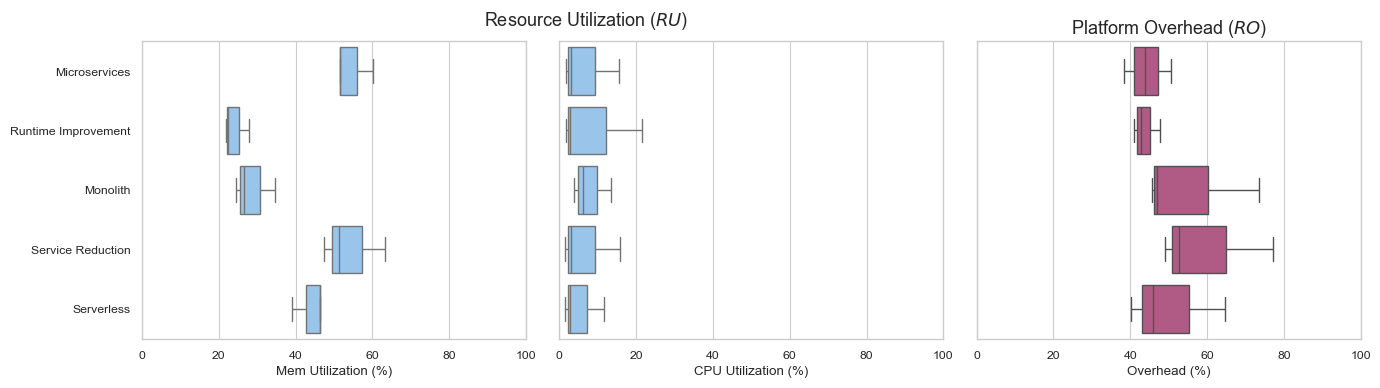

In [12]:
# here we combine the views on utilization and costs and plot them in a single figure based on the focus and workloads we want to compare
focus = full_stack_focus
wls = ["exp_scale_rampup","exp_scale_shaped","exp_scale_pausing"]

fig, ax = plt.subplots(1,3,figsize=(14, 4))

sns.set_context(rc={"font.size": 13, "axes.titlesize": 13, "axes.labelsize": 13, "xtick.labelsize": 13, "ytick.labelsize": 15})

sns.boxplot(
    data=real_total_utilization[(real_total_utilization["exp_branch"].isin(focus))&(real_total_utilization["exp_workload"].isin(wls))],
     y="exp_branch",
      x="mem_utilization",
      ax=ax[0],
      color="C3"
      )
ax[0].set_xlabel("Mem Utilization (%)")

ax[0].set_ylabel("")

ax[0].set_yticklabels([lable_names[x.get_text()] for x in ax[0].get_yticklabels()])
ax[0].set_xlim(0,100)
sns.boxplot(data= real_total_utilization[(real_total_utilization["exp_branch"].isin(focus))&(real_total_utilization["exp_workload"].isin(wls))], y="exp_branch", x="cpu_utilization",ax=ax[1],color="C3")

ax[1].set_xlabel("CPU Utilization (%)")
ax[1].set_ylabel("")
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[1].set_xlim(0,100)

left_ax = ax[0].get_position()
right_ax = ax[1].get_position()
center_x = (left_ax.x0 + right_ax.x1) / 2 + 0.05
center_y = left_ax.y1 + 0.05  # Slightly above the top of the axes

# Add a custom title between plot 1 and plot 2
title = 'Resource Utilization ($RU$)'
fig.text(center_x, center_y, title, ha='center')

sns.boxplot(data= runtime_overhead_cost[(runtime_overhead_cost["exp_branch"].isin(focus))&(runtime_overhead_cost["exp_workload"].isin(wls))], y="exp_branch", x="cost",color="C9",ax=ax[2])
ax[2].set_ylabel("")
ax[2].set_yticklabels([])
ax[2].set_yticks([])
ax[2].set_xlabel("Overhead (%)")
ax[2].set_title("Platform Overhead ($RO$)")
ax[2].set_xlim(0,100)
fig.set_tight_layout(True)

## Scaling and Energy Consumption

In [13]:
# calculate resources allowances

pods = pods_data.copy()
pods["type"] = pods["pod_name"].apply(lambda x: "pod" if x.startswith("teastore") else "function" if x.startswith("auth") else "infra")
pods = pods[pods["type"] != "infra"]
pods["service"] = pods["pod_name"].apply(lambda x: "-".join(x.split("-")[0:2]))
pods["service"].unique()
pods.set_index("run_time")

pods_scale = pods.groupby(["exp_branch","exp_workload","run_iteration","run_time","service"])["name"].count().reset_index()


def calulate_resouce_allowence_for_cost(row):
    if not row["service"] in general_allowance.keys() and not row["service"].startswith("auth") :
        return row
    else:
        
        if row["service"].startswith("auth"):
            cpu = general_allowance["auth"]["cpu"]
            memory = general_allowance["auth"]["memory"]
        else:
            cpu = general_allowance[row["service"]]["cpu"]
            memory = general_allowance[row["service"]]["memory"]
        row["cpu_limit"] = cpu 
        row["mem_limit"] = memory 
        
        return row

pods = pods.apply(calulate_resouce_allowence_for_cost, axis=1, result_type="expand")

pods["mem_utilization"] = 100*pods["memory_usage"] / pods["mem_limit"]
pods["cpu_utilization"] = 100*(1000*pods["cpu_usage"]) / pods["cpu_limit"]

pods["under_utilized"] = 1
pods.loc[(pods["mem_utilization"] < 49) & (pods["cpu_utilization"] < 49),"under_utilized"] = 0

pods["over_utilized"] = 1
pods.loc[(pods["mem_utilization"] > 90) | (pods["cpu_utilization"] > 90),"over_utilized"] = 0

pod_scaling_behavior = pods.groupby(["exp_branch","exp_workload","run_iteration"]+["service","run_time"])[["under_utilized","over_utilized","wattage_kepler"]].agg(["sum","count"])
service_utilization = pod_scaling_behavior
service_utilization["under"] = service_utilization[("under_utilized","count")] - service_utilization[("under_utilized","sum")]
service_utilization["over"] =  service_utilization[("over_utilized","count")] - service_utilization[("over_utilized","sum")]
service_utilization["count"] = service_utilization[("over_utilized","count")]
service_utilization.loc[(service_utilization["count"] == 1) & (service_utilization["under"]==1),"under"] = 0
service_utilization.loc[(service_utilization["count"] == 3) & (service_utilization["over"]==3),"over"] = 0
service_utilization.loc[(service_utilization["under"] > 0),"waste"] = service_utilization[("wattage_kepler","sum")]

service_utilization.columns = service_utilization.columns.droplevel(1)
service_utilization = service_utilization.reset_index()[["exp_branch","exp_workload","run_iteration","service","run_time","under","over","count","waste"]]

melt_service_utilization =  service_utilization.melt(id_vars=["exp_branch","exp_workload","run_iteration"]+["service","run_time"], value_vars=["under","over"])


service_utilization_error = melt_service_utilization[melt_service_utilization["value"] > 0].groupby(["exp_branch","exp_workload","run_time"])["value"].sum().reset_index()

scaling_error =  melt_service_utilization.groupby(["exp_branch","exp_workload"])["value"].sum().reset_index()
scaling_error

scaling_waste = service_utilization.groupby(["exp_branch","exp_workload"])["waste"].sum().reset_index()


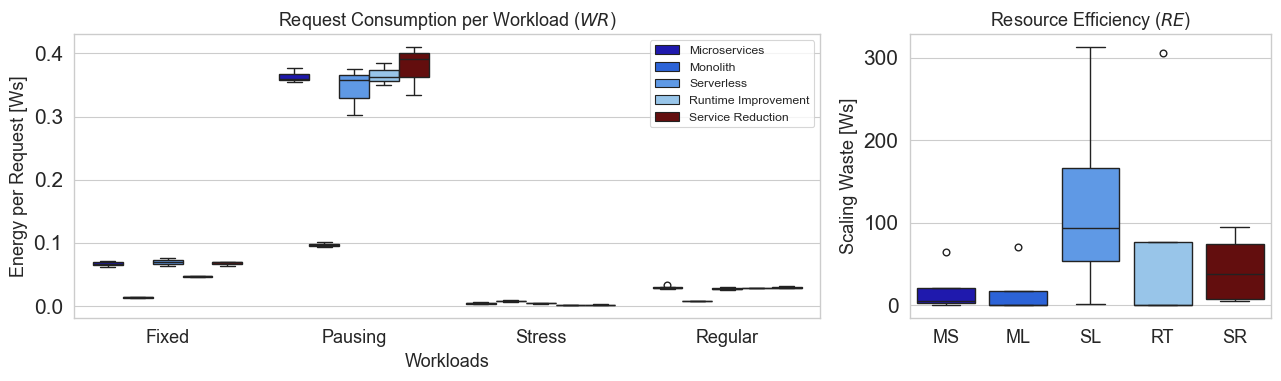

In [18]:
wdf = pods_energy_data.merge(
    how="left",
    right=run_stats_data,
    on=run_vars,
    validate="one_to_one",
)
wdf["ws_per_rq"] = wdf["wattage_kepler"] / wdf["Success Count"]
wdf["mems_per_rq"] = wdf["memory_usage"] / wdf["Success Count"]
wdf["cpus_per_rq"] = wdf["cpu_usage"] / wdf["Success Count"]

cols = ["ws_per_rq", "cpus_per_rq", "mems_per_rq"]

short_labels = {
    "baseline_vanilla_full": "MS",
    'monolith_feature_monolith_full': "ML",
    'serverless_feature_serverless_full' : "SL",
    'jvm_jvm-impoove_full': "RT",
    'norec_feature_norecommendations_full' : "SR",
}

wdff = wdf[wdf.exp_branch.isin(full_stack_focus)]

fig = plt.figure(figsize=(13, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1.1])
sns.set_style("whitegrid")
sns.set_context(rc={"font.size": 13, "axes.titlesize": 13, "axes.labelsize": 13, "xtick.labelsize": 13, "ytick.labelsize": 15})

g = fig.add_subplot(gs[0:2])
# Request Consumption (Links)

ws_plot = sns.boxplot(
    data=wdff,
    # kind="box",
    hue="exp_branch",
    hue_order=short_labels.keys(),
    # order=short_labels.keys(),
    y="ws_per_rq",
    # sharey=False,
    x="exp_workload",
    palette=palette,
    # height=6,
    # aspect=.7,
    ax=g
)


g.set_ylabel("Energy per Request [Ws]")
g.set_xlabel("Workloads")
g.set_title("Request Consumption per Workload ($WR$)")

g.set_xticklabels([lable_names[x.get_text()] for x in g.get_xticklabels()])


handles, labels = g.get_legend_handles_labels()
labels = [lable_names[label] for label in labels]
g.legend(handles, labels, title="")

# Efficiency / Scaling Waste (Rechts)

f = fig.add_subplot(gs[2])
boxplot2= sns.boxplot(
    data=scaling_waste[scaling_waste["exp_branch"].isin(full_stack_focus)],
    x="exp_branch",
    order=short_labels.keys(),
    hue_order=short_labels.keys(),

    y="waste",
    hue="exp_branch",
    ax=f,
    palette=palette
)



f.set_title("Resource Efficiency ($RE$)")
f.set_xlabel("")
f.set_ylabel("Scaling Waste [Ws]")
f.set_xticklabels([short_labels[x.get_text()] for x in f.get_xticklabels()])

plt.tight_layout()